In [1]:
__author__ = "Victor Xu"
__email__ = "victor.c.xu@gmail.com"
__website__ = "victorxu.me"

__copyright__ = "Copyright 2019, Victor Xu"

In [2]:
#import re
import pandas as pd
import numpy as np
import warnings

from sqlalchemy import create_engine
#from tqdm import tqdm_notebook
#from nba_py import player
#from time import sleep
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

# Data Modeling
#### Spliting train test data

In [3]:
engine = create_engine("sqlite:///db/nba.db", echo=False)
with engine.connect() as conn:
    data = pd.read_sql('player_stats', conn, index_col='nba_id')
    
data.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min,espn_position
nba_id,,,,,,,,,,,,,,,,,,,,
101106,0.666666,0.277778,0.055556,0.000000,0.000000,0.000000,36,0.000000,0.999990,0.000000,0.0,0.000000,0.000000,1,10.1,26.9,7.2,2.0,350.758333,C
101107,0.188940,0.173579,0.052227,0.132104,0.062980,0.390169,651,0.619047,0.238095,0.000000,0.0,0.047619,0.095238,21,3.5,14.5,4.4,2.9,4139.115000,PF
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101109,0.134328,0.179104,0.238806,0.037313,0.044776,0.365672,134,0.333332,0.333332,0.333332,0.0,0.000000,0.000000,3,1.4,8.4,13.7,3.0,1744.088333,PG


In [4]:
from sklearn.model_selection import train_test_split

# Dropping players with less than 50 shots attempts
data = data[data.fga >= 50]

X = data.drop('espn_position', axis=1)
y = data[['espn_position']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Manually encode the labels to make it more meaningful for the confusion matrix later
label_encoder_dict = dict([
    ("C",0),
    ("PG",1),
    ("SG",2),
    ("SF",3),
    ("PF",4)
])

y_train = y_train.espn_position.map(label_encoder_dict).values
y_test = y_test.espn_position.map(label_encoder_dict).values

print('X_train:',X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (433, 19)
y_train: (433,)
X_test: (145, 19)
y_test: (145,)


In [5]:
X_train.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
nba_id,,,,,,,,,,,,,,,,,,,
202066,0.251521,0.085193,0.127789,0.123732,0.099391,0.312373,493,0.652174,0.173913,0.043478,0.043478,0.043478,0.043478,23,1.6,9.5,6.0,4.2,2550.921667
201566,0.375424,0.105227,0.241005,0.023761,0.010862,0.243720,1473,0.602941,0.323529,0.029412,0.014706,0.000000,0.029412,68,4.5,23.4,27.8,5.0,5543.090000
1628975,0.147541,0.098361,0.207650,0.071038,0.109290,0.366120,183,0.666666,0.166666,0.166666,0.000000,0.000000,0.000000,6,1.2,4.3,5.7,2.2,576.501667
1626144,0.345946,0.175676,0.197297,0.022973,0.025676,0.232432,740,0.714286,0.160714,0.035714,0.000000,0.000000,0.089286,56,2.0,9.8,14.7,2.9,2851.285000
101181,0.126050,0.042017,0.361345,0.033613,0.042017,0.394958,119,0.624999,0.125000,0.250000,0.000000,0.000000,0.000000,8,1.5,7.4,14.8,2.6,1546.288333


A big chunk of players do not have meaningful number of blocks. We will keep this feature for now and see if the models think they are important later

In [6]:
y_train[:10]

array([2, 1, 1, 1, 1, 0, 0, 2, 4, 0])

### Baseline Predictor /w decision tree & PCA

We are going to use a simple cross validated decision tree as the baseline predictor.

In [16]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', DecisionTreeClassifier(class_weight='balanced'))])

param_grid = {"pca__n_components":[5,10,15,18],
              "clf__max_depth":[5,10,15]}

cv = StratifiedKFold(5, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, verbose=0, scoring='accuracy', cv=cv, n_jobs=-1)

grid_search.fit(X_train, y_train);

baseline_score = grid_search.score(X_test, y_test)
print("Baseline accuracy score is", baseline_score)

Baseline accuracy score is 0.5241379310344828


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standarize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='gini', max_depth=15,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verb

### Multinomial Logistic Regression

Why choose it
    - Predicts probability distribution over k classes, which gives us insight on how close the player is to each position/role
    - Performs well when data is not well separated, which is going to be the case for us. The variance in NBA stat is often quite high

#### Examine Multicollinearity 

Unless extreme, multicollinearity won't affect prediction. It will, however, affect our ability to assert causation and make the model much less interpretable. Since we are only interested in prediction, it's therefore not a big concern but we'll have a look at the VIF just to see what we are dealing with.

In [67]:
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for idx, col in enumerate(X.columns):
    VIF_i = variance_inflation_factor(X.dropna().values, idx)
    vif_data.append([col, VIF_i])

display(pd.DataFrame(vif_data, columns=['Feature', "VIF"]).sort_values("VIF", ascending=False))

,Feature,VIF
7,block_res,1.970510e+12
0,shot_res,7.699119e+11
8,block_in_paint,5.463876e+11
5,shot_above_3,5.140509e+11
1,shot_in_paint,1.617179e+11
2,shot_mid_range,1.441913e+11
9,block_mid_range,4.704014e+10
12,block_above_3,2.936265e+10
4,shot_rcorner_3,2.033008e+10
3,shot_lcorner_3,1.951794e+10


Anything with VIF over 10 exhibits strong multicolinearity with other features, here we are dealing with many feature that has strong correlation with others.

Quickest way to solve this is in this dataset is probably with a combination of standarization, PCA and L1 regularization. 

In [93]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', LogisticRegression(class_weight='balanced', 
                                                max_iter=10000,
                                                multi_class='multinomial',
                                                solver='saga'))])

param_grid = {"clf__penalty":['l1','l2','none'],
              "clf__C":[.5,.75,1,1.25],
              "pca__n_components":[5,10,15,18]
             }

cv = StratifiedKFold(5, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, verbose=0, scoring='accuracy', cv=cv, n_jobs=-1)

grid_search.fit(X_train, y_train);

grid_search.score(X_test, y_test)

0.6701030927835051

In [94]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('standarize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [70]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

cm = confusion_matrix(y_test, grid_search.predict(X_test))

Text(60,0.5,'Ground Truth Label')

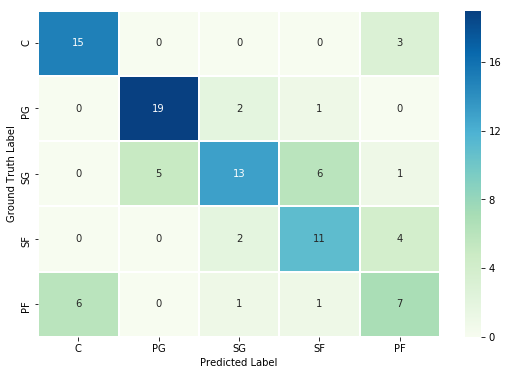

In [71]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 5))
heat_map = sns.heatmap(cm, 
                       annot=True, 
                       fmt="d", 
                       linewidths=1, 
                       ax=ax, 
                       cmap='GnBu',
                       xticklabels=label_encoder_dict.keys(), 
                       yticklabels=label_encoder_dict.keys())

heat_map.set_xlabel("Predicted Label")
heat_map.set_ylabel("Ground Truth Label")

This result is interesting because it shows that based on where a player shoots the ball, and his general stats, we can generally tell which type of player he is. 

Not surprisingly, the difference between a Point Guard and a Shooting Guard is subtle, as misclassification rates are somewhat high between the two groups.

The Power Forward position is also an interesting one, as it often gets misclassified with Center. This makes sense because they have more similar play styles, which is to always play near the restricted zone.

https://sports.stackexchange.com/questions/2172/what-are-the-differences-between-the-power-forward-and-center-positions

## Tree Based Methods

### Random Forest

Why Choose It
    - One of the best out of the box classifiers. It is non-parametric(don't assume underlying data distribution), which makes it robust to many kinds of data and does not require feature preprocessing. 
    - Pretty quick to train compared to XGBoost, which has many more parameters to tune.

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

rf_parameter_grid = {'clf__n_estimators':[100, 500],
                    'clf__max_depth':[8, 12, 16, 18],
                    'clf__min_samples_split':[2, 8, 12, 18]
                    }

rf_gridsearch = GridSearchCV(rf_pipeline, rf_parameter_grid, cv=cv)

In [83]:
rf_gridsearch.fit(X_train, y_train);

In [87]:
rf_gridsearch.score(X_test, y_test)

0.6288659793814433

In [88]:
rf_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=8,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

Text(60,0.5,'Ground Truth Label')

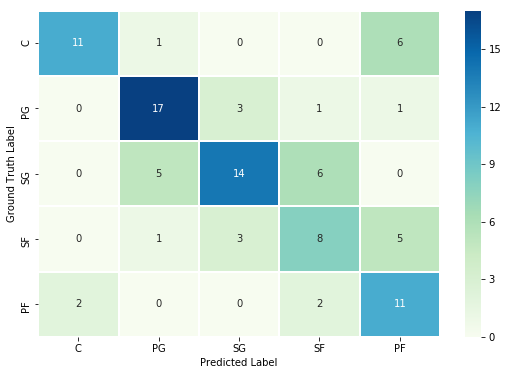

In [99]:
# Draw a heatmap with the numeric values in each cell
cm = confusion_matrix(y_test, rf_gridsearch.predict(X_test))
f, ax = plt.subplots(figsize=(9, 6))
heat_map = sns.heatmap(cm, 
                       annot=True, 
                       fmt="d", 
                       linewidths=1, 
                       ax=ax, 
                       cmap='GnBu',
                       xticklabels=label_encoder_dict.keys(), 
                       yticklabels=label_encoder_dict.keys())

heat_map.set_xlabel("Predicted Label")
heat_map.set_ylabel("Ground Truth Label")

In this case, RF did not perform better than our Multinomial Logistic Regression Classifier. It made similar mistakes compared to the logistic regression model (confusing same types of players), and greater in quantity.

### Boosted Trees

#### XGBoost

In [95]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

xgb_pipeline = Pipeline([('xgb_clf', XGBClassifier(n_jobs=1, learning_rate=0.1, verbose=10))])

xgb_param_grid1 = {
    'xgb_clf__n_estimators':[75],
    'xgb_clf__gamma':[0, 0.5, 1],
    'xgb_clf__max_depth':[3, 6, 9],
    'xgb_clf__reg_alpha':[0, 0.5, 1], 
    'xgb_clf__reg_lambda':[0, 0.5, 1], 
}

cv = StratifiedKFold(5, shuffle=False)

xgb_grid_cv = GridSearchCV(xgb_pipeline, xgb_param_grid1, cv=cv, verbose=0, n_jobs=-1, refit=True)

In [98]:
xgb_grid_cv.fit(X_train, y_train);

In [97]:
xgb_grid_cv.score(X_test, y_test)

0.5979381443298969

In [80]:
xgb_grid_cv.best_estimator_

Pipeline(memory=None,
         steps=[('xgb_clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=None,
                               n_estimators=75, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                               seed=None, silent=True, subsample=1,
                               verbose=10))],
         verbose=False)